# HandcraftBK RAG Agent with LangChain

This notebook creates an integrated RAG agent using LangChain that can:
1. Query product data from the FAISS vector database using semantic search
2. Make API calls to the products endpoint for filtering and sorting

The agent uses LangChain's integration capabilities to provide a seamless experience between semantic search and structured API calls.

## Import Required Libraries

In [109]:
import os
import json
import requests
from typing import Optional
from pydantic import BaseModel, Field

# LangChain components
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# LangChain tools and agent components
from langchain.tools import tool

# LangGraph components

# LLM
from langchain_together import ChatTogether

# Python imports for API interactions
import requests
from urllib.parse import urlencode

# Load environment variables
import dotenv

dotenv.load_dotenv()

True

## Configuration

In [110]:
# Configuration
API_BASE_URL = "http://localhost:3119/api"
VECTOR_STORE_PATH = "./faiss_index"
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")

# Check if OpenAI API key is set
if not TOGETHER_API_KEY:
    print(
        "WARNING: TOGETHER_API_KEY not set. Set it using os.environ['TOGETHER_API_KEY'] = 'your-key'"
    )

## Initialize Embeddings and Vector Store

In [ ]:
# Initialize the HuggingFace embeddings (same model as used in build_vectorstore.ipynb)
model_name = "paraphrase-multilingual-MiniLM-L12-v2"

embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs={"device": "mps"},
    encode_kwargs={"normalize_embeddings": True},
)

# Load the FAISS vector store
try:
    vectorstore = FAISS.load_local(
        VECTOR_STORE_PATH, embeddings, allow_dangerous_deserialization=True
    )
    print(f"Successfully loaded vector store from {VECTOR_STORE_PATH}")
except Exception as e:
    print(f"Error loading vector store: {e}")
    print(
        "Make sure you've run build_vectorstore.ipynb first to create the vector store."
    )
    vectorstore = None

Successfully loaded vector store from ./faiss_index


## API Client Setup

In [112]:
class ProductsApiClient:
    """Client for interacting with the products API"""

    def __init__(self, base_url):
        self.base_url = base_url
        self.session = requests.Session()

    def get_products(self, **params):
        """Get products with optional filtering and sorting"""
        # Remove None values
        params = {k: v for k, v in params.items() if v is not None}
        # Create query string
        query_string = urlencode(params)
        # Make the API request
        url = f"{self.base_url}/products?{query_string}"

        try:
            response = self.session.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            return {"error": str(e)}

    def get_product_by_slug(self, slug):
        """Get a specific product by its slug"""
        url = f"{self.base_url}/products/slug/{slug}"

        try:
            response = self.session.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            return {"error": str(e)}


class CategoriesApiClient:
    """Client for interacting with the categories API"""

    def __init__(self, base_url):
        self.base_url = base_url
        self.session = requests.Session()

    def get_menu_categories(self):
        """Get all categories for navigation menu"""
        url = f"{self.base_url}/categories/menu"

        try:
            response = self.session.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            return {"error": str(e)}

    def get_category_by_id(self, id, include_children=False, include_parents=False):
        """Get a specific category by its ID"""
        params = {
            "includeChildren": str(include_children).lower(),
            "includeParents": str(include_parents).lower(),
        }
        query_string = urlencode(params)
        url = f"{self.base_url}/categories/{id}?{query_string}"

        try:
            response = self.session.get(url)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            return {"error": str(e)}


# Initialize the API clients
api_client = ProductsApiClient(API_BASE_URL)
categories_client = CategoriesApiClient(API_BASE_URL)

## Define Custom Tools

In [113]:
class ProductQueryParams(BaseModel):
    """Parameters for querying products API"""

    page: Optional[int] = Field(default=1, description="Page number (starts from 1)")
    limit: Optional[int] = Field(
        default=3, description="Number of items per page (max 100)"
    )
    categoryId: Optional[str] = Field(default=None, description="Filter by category ID")
    minPrice: Optional[int] = Field(default=None, description="Filter by minimum price")
    maxPrice: Optional[int] = Field(default=None, description="Filter by maximum price")
    isActive: Optional[bool] = Field(
        default=True, description="Filter by active status"
    )
    inStock: Optional[bool] = Field(
        default=True, description="Filter by stock availability"
    )
    search: Optional[str] = Field(
        default=None, description="Search in name, description, and tags"
    )
    sortBy: Optional[str] = Field(
        default=None,
        description="Sort field (newest, price-asc, price-desc, popularity, top-seller)",
    )


class CategoryQueryParams(BaseModel):
    """Parameters for querying a single category"""

    id: str = Field(description="Category ID to retrieve")
    includeChildren: Optional[bool] = Field(
        default=True, description="Include children categories"
    )
    includeParents: Optional[bool] = Field(
        default=True, description="Include parent categories"
    )


@tool
def get_menu_categories() -> str:
    """Get all main categories for the navigation menu.

    Use this when the user asks about:
    - Main/Available product categories

    Returns:
        A structured list of all available categories
    """
    response = categories_client.get_menu_categories()

    if "error" in response:
        return json.dumps({"error": response["error"]}, ensure_ascii=False)

    # Format the categories in a readable way
    if "categories" in response and len(response["categories"]) > 0:
        formatted_categories = []

        for category in response["categories"]:
            cat_info = {
                "id": category.get("id"),
                "name": category.get("name"),
                "pathUrl": category.get("pathUrl"),
                "productsCount": category.get("productsCount", 0),
                "isLeaf": category.get("isLeaf", False),
            }
            formatted_categories.append(cat_info)

        return json.dumps({"categories": formatted_categories}, ensure_ascii=False)
    else:
        return json.dumps({"message": "No categories found"}, ensure_ascii=False)


@tool
def get_category_by_id(params: CategoryQueryParams) -> str:
    """Get details about a specific category by its ID.

    Use this when the user asks about:
    - Details of a specific product category
    - Products within a specific category

    Args:
        params: Parameters for retrieving category information

    Returns:
        Detailed information about the category, including parents and children if requested
    """
    # Convert params to dictionary
    params_dict = params.model_dump(exclude_none=True)
    category_id = params_dict.pop("id")

    # Get category details from API
    response = categories_client.get_category_by_id(category_id, **params_dict)

    if "error" in response:
        return json.dumps({"error": response["error"]}, ensure_ascii=False)

    # Format the category details in a readable way
    formatted_category = {
        "id": response.get("id"),
        "name": response.get("name"),
        "pathUrl": response.get("pathUrl"),
        "productsCount": response.get("productsCount", 0),
        "isLeaf": response.get("isLeaf", False),
    }

    # Add parents if available
    if "parents" in response and response["parents"]:
        formatted_category["parents"] = [
            {
                "id": parent.get("id"),
                "name": parent.get("name"),
                "pathUrl": parent.get("pathUrl"),
            }
            for parent in response["parents"]
        ]

    # Add children if available
    if "children" in response and response["children"]:
        formatted_category["children"] = [
            {
                "id": child.get("id"),
                "name": child.get("name"),
                "pathUrl": child.get("pathUrl"),
                "productsCount": child.get("productsCount", 0),
            }
            for child in response["children"]
        ]

    return json.dumps(formatted_category, ensure_ascii=False)


@tool
def query_products_api(params: ProductQueryParams) -> str:
    """Query the products API with filtering and sorting options.

    Use this when the user wants to:
    - Find products in specific price ranges
    - Sort products by newest, price-asc (Price from low to high), price-desc (Price from high to low), popularity, top-seller.
    - Check products that are in stock
    - Limit the number of products returned to 3 per query.

    Examples:
    - What are your most popular products?
    - Do you have any wooden bowls in stock?
    - Sort products by price from low to high

    Args:
        params: Parameters for filtering and sorting products

    Returns:
        JSON response from the API as a string
    """
    # Convert params to dictionary
    params_dict = params.model_dump(exclude_none=True)

    # Get products from API
    response = api_client.get_products(**params_dict)
    print("API Response:", response)
    # Format the results in a more readable way
    if "items" in response and len(response["items"]) > 0:
        products_info = []
        for product in response["items"]:
            info = {
                "id": product.get("id"),
                "name": product.get("name"),
                "price": product.get("price", 0),
                "currency": product.get("currency", "VND"),
                "rating": product.get("rating"),
                "inStock": product.get("stockQuantity", 0) > 0,
                "description": product.get("description", "")[:100]
                + ("..." if len(product.get("description", "")) > 100 else ""),
                "featured_image": product.get("images")[0]
                if product.get("images") and len(product.get("images")) > 0
                else None,
                "slug": product.get("slug"),
                "stockQuantity": product.get("stockQuantity"),
                "category": product.get("category").get("name"),
            }
            products_info.append(info)

        result = {
            "products": products_info,
        }
        return json.dumps(result, ensure_ascii=False)
    else:
        return json.dumps(
            {"message": "No products found matching the criteria"}, ensure_ascii=False
        )

## Setup Vector Store Retriever

In [114]:
# Create retriever from the vector store
if vectorstore is not None:
    retriever = vectorstore.as_retriever(
        search_type="similarity", search_kwargs={"k": 3}
    )
else:
    print("Warning: Vector store is not available, retriever will not work")
    retriever = None


# Define a tool that uses the retriever
@tool
def semantic_search(query: str) -> str:
    """Search for products or categories semantically using the vector database.

    Use this tool for natural language queries about products when:
    - The user asks about product features or characteristics
    - The user wants recommendations based on specific needs
    - The user asks general questions about product types or categories
    - If category name is not available, request to get_category_by_id to get category name.
    - You need detailed product information that might not be captured by API filters

    Example queries:
    - Which products would be good as gifts?
    - What are the characteristics of bamboo products?
    - Can you recommend products that represent Vietnamese culture?

    Args:
        query: The natural language search query

    Returns:
        Relevant product or category information based on the query
    """
    if retriever is None:
        return "Vector store is not available."

    docs = retriever.invoke(query)

    results = []
    for i, doc in enumerate(docs):
        source_type = doc.metadata.get("source", "unknown")

        if source_type == "product":
            result = f"Product {i + 1}:\n"
        elif source_type == "category":
            result = f"Category {i + 1}:\n"
        result += doc.page_content
        result += json.dumps(doc.metadata, ensure_ascii=False)

        results.append(result)

    return "\n\n".join(results)

## Initialize LLM and Create LangChain Agent

In [115]:
llm = ChatTogether(
    temperature=0,
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo-Free",
    api_key=TOGETHER_API_KEY,
)

tools = [
    query_products_api,
    semantic_search,
    get_menu_categories,
    get_category_by_id,
]

In [116]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ..."
            print(msg_repr)
            _printed.add(message.id)

## Define Agent Prompt

In [117]:
# Create agent prompt
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a helpful shopping assistant for HandcraftBK, a Vietnamese artisanal handicraft store.
You help customers find and learn about Vietnamese handicraft products and categories.
Instruction for the tool to assist customers has been provided.

When providing category information, format it in markdown style with the following details in order:
1. ### [Category Name]
2. **Products Count:** [Number of products in this category]
3. Include category path url [Category path URL] in pattern (/categories/[category-slug])

Example category information format:
```
### Handcrafted Wooden Bowls
**Products Count:** 25
[Category Url] /categories/handcrafted-wooden-bowls-c2323
```

When providing product information by using semantic_search:
- Description: A summary of the product description about 40-60 words base on [Description] in result
- Use get_category_by_id to get category name from categoryId.

When providing product information, format it in markdown style with the following details in order:
1. ### [Product Name]
2. **Price:** [Price formatted with comma separators] VND (if price is 0, use "Contact us"/"Liên hệ")
3. **Description:** A concise summary of the product description about 40-60 words
4. **Category:** [Category Name]
5. **Rating:** [Rating]/5 ([Review Count] reviews)
6. **Stock:** [In stock/Out of stock] ([Stock Quantity] available)
7. Include product path url (/products/[product-slug])
8. Include a feature image link [featured_image]

Example product information format:
```
### Handcrafted Wooden Bowl
**Price:** 299,000 VND
**Description:** Beautiful handcrafted wooden bowl made from sustainable oak wood...
**Category:** Kitchenware
**Rating:** 4.5/5 (42 reviews)
**Stock:** In stock (25 available)
[View Product](/products/handcrafted-wooden-bowl-p3434)
![Product Image](https://example.com/images/bowl1.jpg)
```

Always respond in a helpful and friendly manner. Format prices in Vietnamese Dong (VND) with comma separators (e.g., 1,460,000 VND).
Please answer only in English/Vietnamese.
If you do not know the answer, respond with "I don't know" or "Xin lỗi, tôi không biết."
""",
        ),
        MessagesPlaceholder(
            variable_name="messages"
        ),  # Use MessagesPlaceholder for history
    ]
)

## Create the LangGraph Agent

In [118]:
from langchain_core.runnables import Runnable, RunnableConfig
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # Invoke the runnable with the original state (containing 'messages')
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


assistant_runnable = prompt | llm.bind_tools(tools)

## Define graph

In [119]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

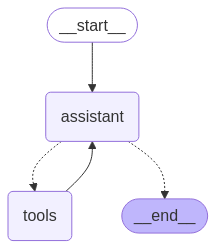

In [120]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Agent Interface

Run this cell to interact with the agent.

In [121]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# Example usage
query = "Which products would be good as gifts?"
_printed = set()
events = graph.stream({"messages": ("user", query)}, config, stream_mode="values")
for event in events:
    _print_event(event, _printed)
# print(f"Query: {query}")
# print(f"Response: {response}")

================================ Human Message =================================

Which products would be good as gifts?


================================== Ai Message ==================================
Tool Calls:
  semantic_search (call_nbv791ak978hsuryde18haxp)
 Call ID: call_nbv791ak978hsuryde18haxp
  Args:
    query: products that would be good as gifts
================================= Tool Message =================================
Name: semantic_search

Product 1:
Product Name: Bộ quà Tết hộp đựng mứt tết MNV - QT203
Description: Bộ sản phẩm Tết với họa tiết đào là lựa chọn lý tưởng để đựng kẹo, mứt và các vật dụng khác, mang đến điểm nhấn sắc sảo cho phòng khách gia đình trong dịp Tết.

Sản phẩm được làm từ cốt gỗ nguyên cây hoặc gỗ MDF, kết hợp với kỹ thuật sơn mài cao cấp. Các họa tiết đào được vẽ tỉ mỉ, bề mặt phủ nhiều lớp sơn tạo độ sáng bóng và bền màu.

Sản phẩm đã được chứng nhận an toàn với thực phẩm, đảm bảo chất lượng cao. Khách hàng có thể yêu cầu in logo công ty lên nắp hộp, làm quà tặng Tết, quà hội thảo hoặc dành cho người thân, bạn bè trong dịp xuân đến.
Specifications:
- package_c

## Example Queries

Here are some example queries you can try with the agent:

### API-based Queries (uses query_products_api):
- Show me products under 500,000 VND
- What are your most popular products?
- Do you have any wooden bowls in stock?
- Sort products by price from low to high
- Show me products in the home decor category

### Semantic Search Queries (uses semantic_search):
- What materials are used in your lacquer products?
- Tell me about traditional Vietnamese handicraft techniques
- Which products would be good as gifts?
- What are the characteristics of bamboo products?
- Can you recommend products that represent Vietnamese culture?

### Specific Product Queries (uses get_product_by_slug or semantic_search):
- Tell me about the Handcrafted Wooden Bowl
- What are the dimensions of the lacquer painting?
- Is the bamboo basket handmade?

### Category Queries (uses get_menu_categories or get_category_by_id):
- What categories of products do you have?
- Tell me about the home decor category
- What subcategories are under the kitchenware category?